In [ ]:
pip install pydicom nibabel numpy torch torchvision segmentation-models-pytorch scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=3bf2abacd821e80a8737eb08c9be307240a1cef4687375c6c6efbd476d25f59c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=715af4c7e474209454dae7fbdc30c0574241618351b9167ea63fd9d591d440e9
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytor

Train Set Samples:
Validation Set Samples:
Test Set Samples:


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


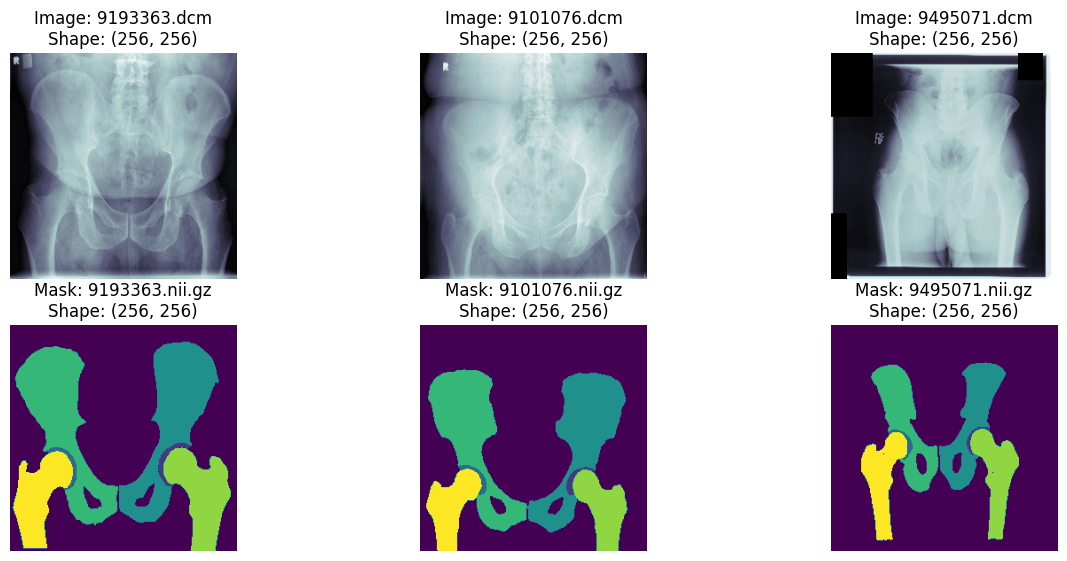

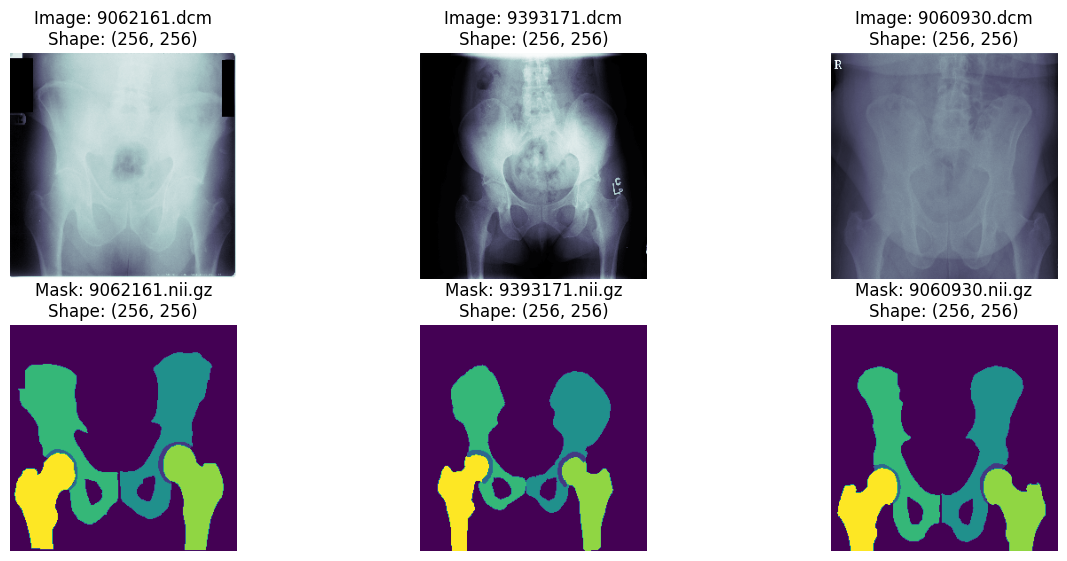

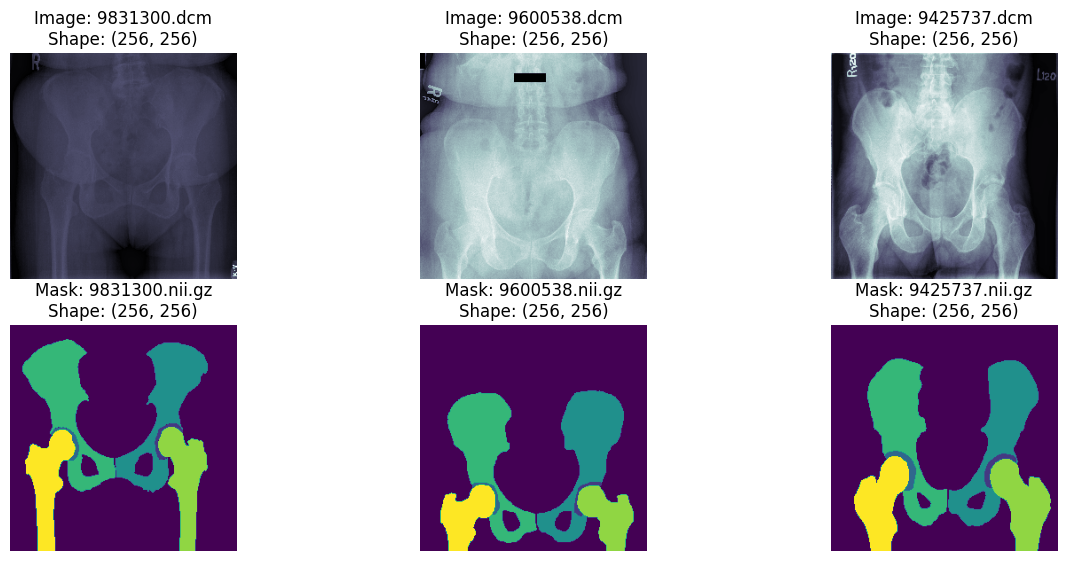

In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import random
img_root = "JHIR_Hip_Knee_Datasets/Hip/Images"
mask_root = "JHIR_Hip_Knee_Datasets/Hip/Annotations"
class MulticlassHipSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, image_files, mask_files, num_classes, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.num_classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        dicom_image = pydicom.dcmread(os.path.join(self.img_root, self.img_files[idx]))
        image = dicom_image.pixel_array.astype(np.float32)
        annotation = nib.load(os.path.join(self.mask_root, self.mask_files[idx]))
        annotation_data = annotation.get_fdata()
        if len(annotation_data.shape) == 3:
            annotation_data = annotation_data[:, :, 0]
        annotation_data = np.rot90(annotation_data, k=7)
        if annotation_data.ndim > 2 and annotation_data.shape[-1] != 1:
            raise ValueError('Mask has multiple channels')

        if image.shape != annotation_data.shape:
            zoom_factors = np.array(image.shape) / np.array(annotation_data.shape)
            annotation_data = zoom(annotation_data, zoom_factors, order=0)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]
        annotation_data_onehot = self.one_hot_encode(annotation_data)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=annotation_data_onehot)
            image = transformed["image"]
            annotation_data_onehot = transformed["mask"]

        return image, annotation_data_onehot

    def one_hot_encode(self, mask):
        one_hot_mask = np.zeros((self.num_classes, *mask.shape), dtype=np.float32)
        for class_idx in range(self.num_classes):
            one_hot_mask[class_idx][mask == class_idx] = 1.0
        return one_hot_mask

image_files = sorted(os.listdir(img_root))
mask_files = sorted(os.listdir(mask_root))
paired_files = list(zip(image_files, mask_files))
random.shuffle(paired_files)

train_size = int(0.7 * len(paired_files))
valid_size = int(0.1 * len(paired_files))
test_size = len(paired_files) - train_size - valid_size

train_pairs = paired_files[:train_size]
valid_pairs = paired_files[train_size:train_size + valid_size]
test_pairs = paired_files[train_size + valid_size:]

num_classes = 7

augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
], is_check_shapes=False)

train_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in train_pairs], [p[1] for p in train_pairs], num_classes, transforms=augmentations)
valid_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in valid_pairs], [p[1] for p in valid_pairs], num_classes, transforms=augmentations)
test_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in test_pairs], [p[1] for p in test_pairs], num_classes, transforms=augmentations)

def visualize_samples(dataset, num_samples=3, img_cmap='bone'):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        image, mask = dataset[i]
        image_np = image.squeeze().numpy()
        mask_np = mask.argmax(axis=0)

        img_filename = dataset.img_files[i]
        mask_filename = dataset.mask_files[i]

        plt.subplot(3, num_samples, i + 1)
        plt.imshow(image_np, cmap=img_cmap)
        plt.axis('off')
        plt.title(f'Image: {img_filename}\nShape: {image_np.shape}')

        plt.subplot(3, num_samples, num_samples + i + 1)
        plt.imshow(mask_np, cmap='viridis', vmin=0, vmax=dataset.num_classes - 1)
        plt.axis('off')
        plt.title(f'Mask: {mask_filename}\nShape: {mask_np.shape}')

print("Train Set Samples:")
visualize_samples(train_set, num_samples=3)
print("Validation Set Samples:")
visualize_samples(valid_set, num_samples=3)
print("Test Set Samples:")
visualize_samples(test_set, num_samples=3)

plt.show()


Epoch 1/25, Training IoU: 0.4957012847504195
Epoch 1/25, Validation IoU: 0.649193474650383
Epoch 2/25, Training IoU: 0.6968434724737617
Epoch 2/25, Validation IoU: 0.7442173510789871
Epoch 3/25, Training IoU: 0.7773665794554878
Epoch 3/25, Validation IoU: 0.7760229855775833
Epoch 4/25, Training IoU: 0.8281940217403805
Epoch 4/25, Validation IoU: 0.8231707513332367
Epoch 5/25, Training IoU: 0.8580091735895943
Epoch 5/25, Validation IoU: 0.8389995276927948
Epoch 6/25, Training IoU: 0.873122504528831
Epoch 6/25, Validation IoU: 0.8497220009565354
Epoch 7/25, Training IoU: 0.8839187262689366
Epoch 7/25, Validation IoU: 0.8553215444087983
Epoch 8/25, Training IoU: 0.8918798912097426
Epoch 8/25, Validation IoU: 0.853897488117218
Epoch 9/25, Training IoU: 0.8990062615450691
Epoch 9/25, Validation IoU: 0.8599444478750229
Epoch 10/25, Training IoU: 0.9049879772698178
Epoch 10/25, Validation IoU: 0.8597190409898758
Epoch 11/25, Training IoU: 0.9098681562087115
Epoch 11/25, Validation IoU: 0.8705

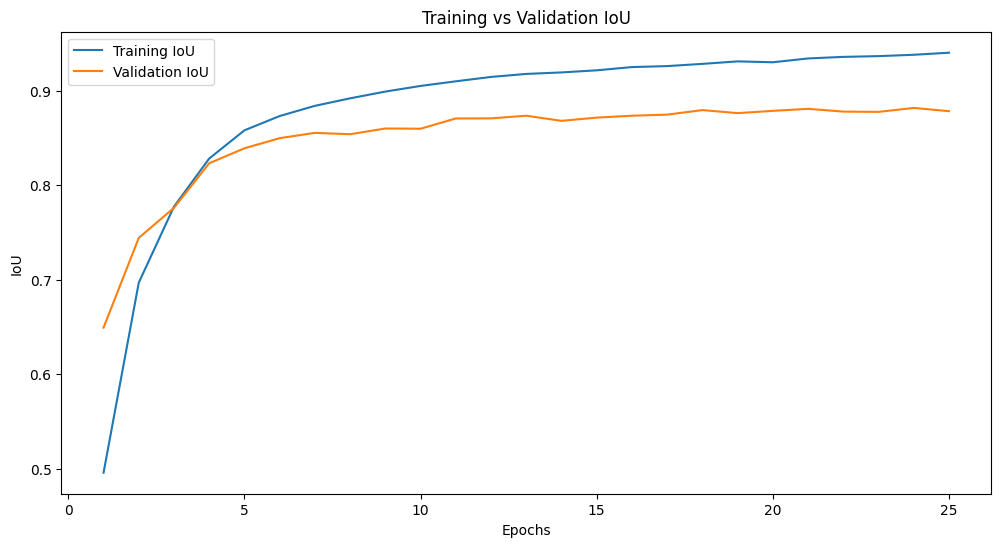

In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import random
import segmentation_models_pytorch as smp

def compute_iou(pred, target, num_classes):
    pred = (pred > 0.5).float()
    intersection = torch.sum(pred * target, dim=(1, 2))
    union = torch.sum((pred + target) > 0, dim=(1, 2))
    iou = (intersection + 1e-10) / (union + 1e-10)
    return torch.mean(iou).item()

class MulticlassHipSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, image_files, mask_files, num_classes, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.num_classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        dicom_image = pydicom.dcmread(os.path.join(self.img_root, self.img_files[idx]))
        image = dicom_image.pixel_array.astype(np.float32)
        annotation = nib.load(os.path.join(self.mask_root, self.mask_files[idx]))
        annotation_data = annotation.get_fdata()
        if len(annotation_data.shape) == 3:
            annotation_data = annotation_data[:, :, 0]
        annotation_data = np.rot90(annotation_data, k=7)
        if annotation_data.ndim > 2 and annotation_data.shape[-1] != 1:
            raise ValueError('Mask has multiple channels')

        if image.shape != annotation_data.shape:
            zoom_factors = np.array(image.shape) / np.array(annotation_data.shape)
            annotation_data = zoom(annotation_data, zoom_factors, order=0)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]

        annotation_data_onehot = self.one_hot_encode(annotation_data)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=annotation_data_onehot)
            image = transformed["image"]
            annotation_data_onehot = transformed["mask"]

        return image, annotation_data_onehot

    def one_hot_encode(self, mask):
        one_hot_mask = np.zeros((self.num_classes, *mask.shape), dtype=np.float32)
        for class_idx in range(self.num_classes):
            one_hot_mask[class_idx][mask == class_idx] = 1.0
        return one_hot_mask



image_files = sorted(os.listdir(img_root))
mask_files = sorted(os.listdir(mask_root))
paired_files = list(zip(image_files, mask_files))
random.shuffle(paired_files)


train_size = int(0.7 * len(paired_files))
valid_size = int(0.1 * len(paired_files))
test_size = len(paired_files) - train_size - valid_size

train_pairs = paired_files[:train_size]
valid_pairs = paired_files[train_size:train_size + valid_size]
test_pairs = paired_files[train_size + valid_size:]

num_classes = 7


augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
], is_check_shapes=False)


train_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in train_pairs], [p[1] for p in train_pairs], num_classes, transforms=augmentations)
valid_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in valid_pairs], [p[1] for p in valid_pairs], num_classes, transforms=augmentations)
test_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in test_pairs], [p[1] for p in test_pairs], num_classes, transforms=augmentations)


model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    classes=num_classes,
)


optimizer = optim.Adam(model.parameters(), lr=0.0001)

criterion = torch.nn.BCEWithLogitsLoss()

num_epochs = 25

train_ious = []
valid_ious = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=4, shuffle=False, num_workers=2)

for epoch in range(num_epochs):
    model.train()
    train_epoch_iou = 0

    for batch in train_loader:
        images, masks = batch
        optimizer.zero_grad()
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        batch_iou = compute_iou((outputs.sigmoid() > 0.5).float(), masks, num_classes)
        train_epoch_iou += batch_iou

    train_epoch_iou /= len(train_loader)
    train_ious.append(train_epoch_iou)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training IoU: {train_epoch_iou}")

    model.eval()
    valid_epoch_iou = 0

    with torch.no_grad():
        for batch in valid_loader:
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            batch_iou = compute_iou((outputs.sigmoid() > 0.5).float(), masks, num_classes)

            valid_epoch_iou += batch_iou

    valid_epoch_iou /= len(valid_loader)
    valid_ious.append(valid_epoch_iou)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation IoU: {valid_epoch_iou}")

torch.save(model.state_dict(), 'unet_resnet18_multiclass_model_weights.pth')

plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_ious, label='Training IoU')
plt.plot(range(1, num_epochs + 1), valid_ious, label='Validation IoU')
plt.title('Training vs Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

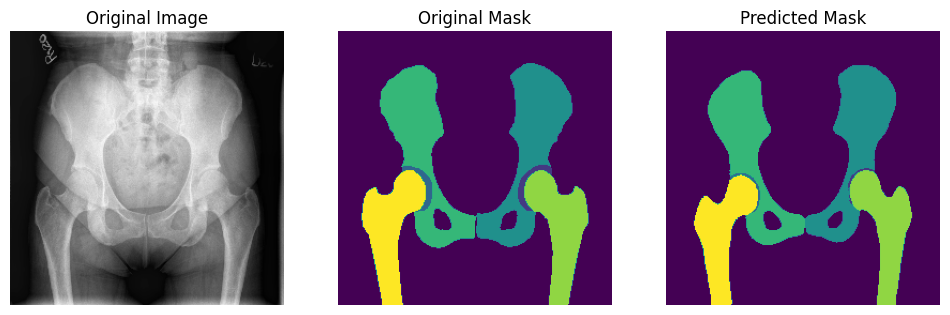

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

test_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in test_pairs], [p[1] for p in test_pairs], num_classes, transforms=augmentations)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

def visualize_single_sample(test_loader, model):
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            images, masks = batch
            outputs = model(images)
            original_mask = torch.argmax(masks.squeeze(0), dim=0).cpu().numpy()
            predicted_mask = torch.argmax(outputs.squeeze(0), dim=0).cpu().numpy()
            image = images.squeeze(0).permute(1, 2, 0).cpu().numpy()

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(image, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(original_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
            plt.title('Original Mask')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(predicted_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.show()
            break

visualize_single_sample(test_loader, model)

In [ ]:

test_ious = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        images, masks = batch
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        batch_iou = compute_iou((outputs.sigmoid() > 0.5).float(), masks, num_classes)
        test_ious.append(batch_iou)

test_mean_iou = np.mean(test_ious)

print(f"Test Mean IoU: {test_mean_iou}")



Test Mean IoU: 0.9203600853489292


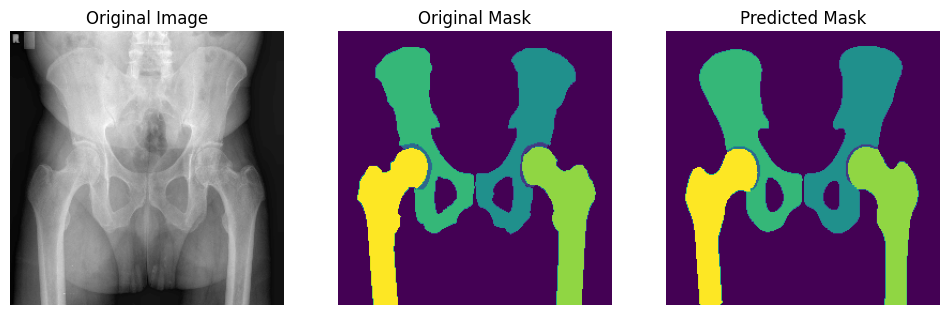

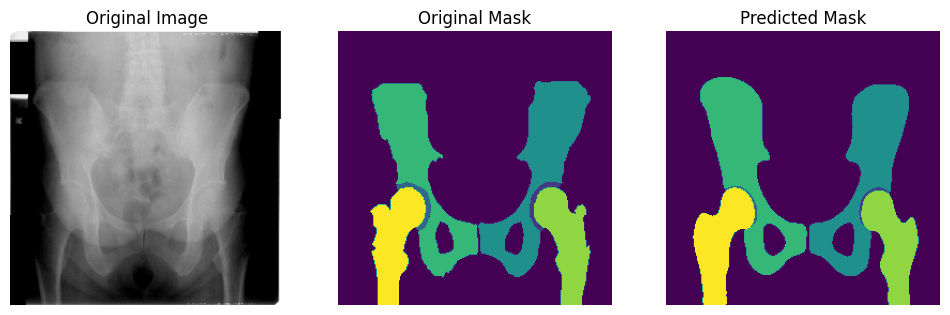

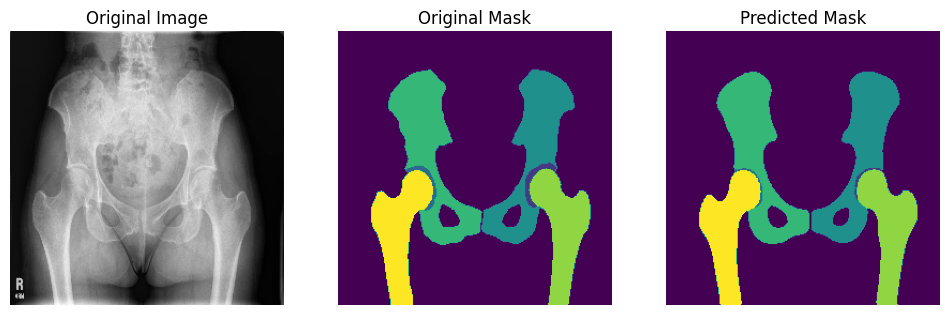

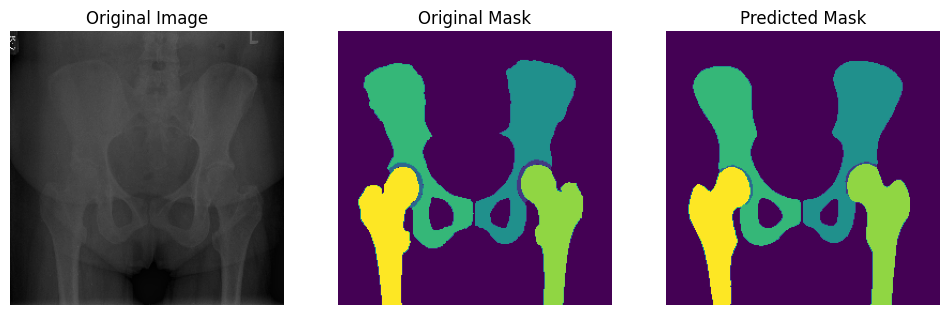

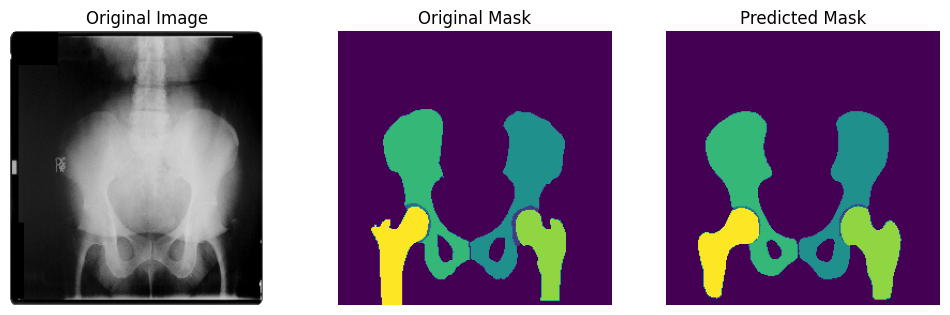

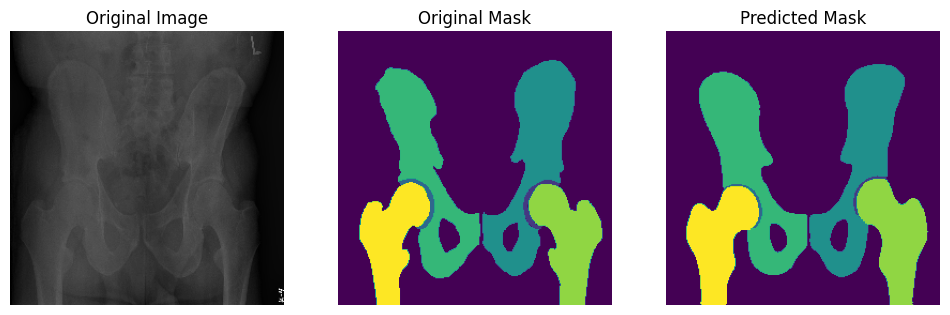

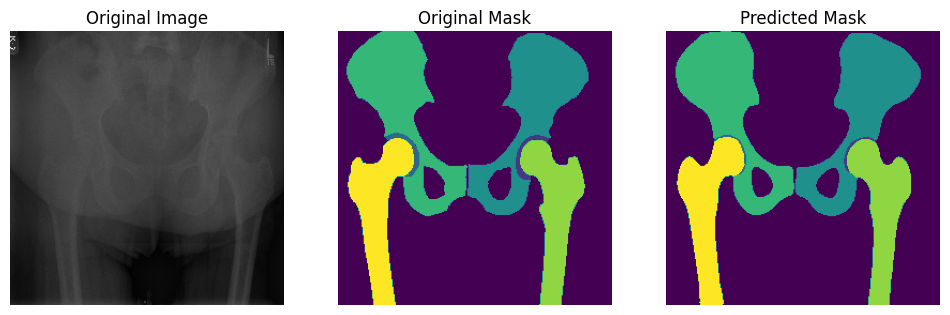

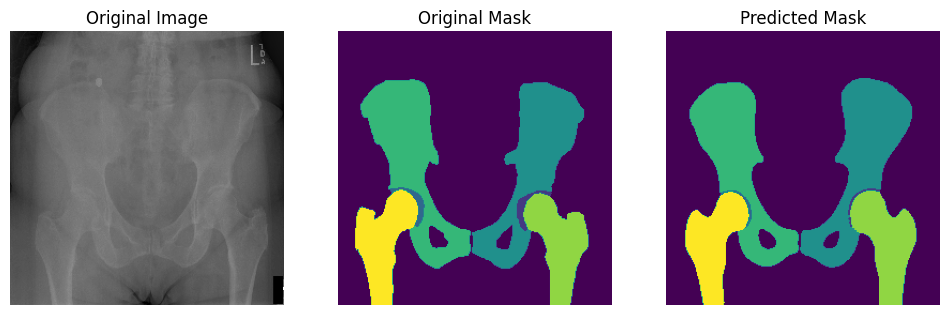

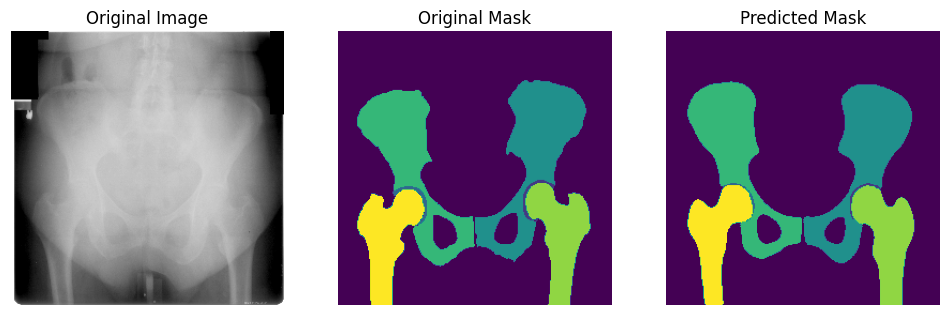

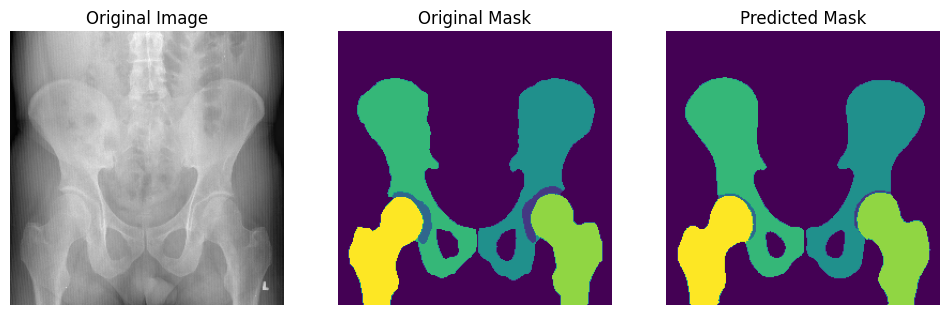

In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
import torch
import random
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

img_root = 'JHIR_Hip_Knee_Datasets/Hip/Images'
mask_root = 'JHIR_Hip_Knee_Datasets/Hip/Annotations'

def compute_iou(pred, target, num_classes):
    pred = (pred > 0.5).float()
    intersection = torch.sum(pred * target, dim=(1, 2))
    union = torch.sum((pred + target) > 0, dim=(1, 2))
    iou = (intersection + 1e-10) / (union + 1e-10)
    return torch.mean(iou).item()

class MulticlassHipSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, image_files, mask_files, num_classes, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.num_classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        dicom_image = pydicom.dcmread(os.path.join(self.img_root, self.img_files[idx]))
        image = dicom_image.pixel_array.astype(np.float32)
        annotation = nib.load(os.path.join(self.mask_root, self.mask_files[idx]))
        annotation_data = annotation.get_fdata()
        if len(annotation_data.shape) == 3:
            annotation_data = annotation_data[:, :, 0]
        annotation_data = np.rot90(annotation_data, k=3)
        if annotation_data.ndim > 2 and annotation_data.shape[-1] != 1:
            raise ValueError('Mask has multiple channels')

        if image.shape != annotation_data.shape:
            zoom_factors = np.array(image.shape) / np.array(annotation_data.shape)
            annotation_data = zoom(annotation_data, zoom_factors, order=0)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]

        annotation_data_onehot = self.one_hot_encode(annotation_data)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=annotation_data_onehot)
            image = transformed["image"]
            annotation_data_onehot = transformed["mask"]

        return image, annotation_data_onehot

    def one_hot_encode(self, mask):
        one_hot_mask = np.zeros((self.num_classes, *mask.shape), dtype=np.float32)
        for class_idx in range(self.num_classes):
            one_hot_mask[class_idx][mask == class_idx] = 1.0
        return one_hot_mask

image_files = sorted(os.listdir(img_root))
mask_files = sorted(os.listdir(mask_root))
paired_files = list(zip(image_files, mask_files))
random.shuffle(paired_files)

train_size = int(0.7 * len(paired_files))
valid_size = int(0.1 * len(paired_files))
test_size = len(paired_files) - train_size - valid_size

train_pairs = paired_files[:train_size]
valid_pairs = paired_files[train_size:train_size + valid_size]
test_pairs = paired_files[train_size + valid_size:]

augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
], is_check_shapes=False)

num_classes = 7
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=1,
    classes=num_classes,
)

saved_model_path = 'unet_resnet18_multiclass_model_weights After 25 Epoch 92iou.pth'
checkpoint = torch.load(saved_model_path)
model.load_state_dict(checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def create_test_loader(test_pairs, augmentations, num_classes):
    test_set = MulticlassHipSegmentationDataset(
        img_root,
        mask_root,
        [p[0] for p in test_pairs],
        [p[1] for p in test_pairs],
        num_classes,
        transforms=augmentations
    )
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    return test_loader

def visualize_single_sample(images, masks, model):
    model.eval()
    with torch.no_grad():
        images = images.squeeze(0)
        masks = masks.squeeze(0)
        outputs = model(images.unsqueeze(0))
        original_mask = torch.argmax(masks, dim=0).cpu().numpy()
        predicted_mask = torch.argmax(outputs.squeeze(0), dim=0).cpu().numpy()
        image = images.permute(1, 2, 0).cpu().numpy()

        if image.shape[-1] == 1:
            image = image.squeeze(-1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(original_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
        plt.title('Original Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

random_10_pairs = random.sample(test_pairs, 10)

random_10_loader = create_test_loader(random_10_pairs, augmentations, num_classes)

for images, masks in random_10_loader:
    visualize_single_sample(images, masks, model)


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 1/25, Training IoU: 0.16832955751348944


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 1/25, Validation IoU: 0.2307355970144272
Epoch 1/25, Model saved with Validation IoU: 0.2307355970144272


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 2/25, Training IoU: 0.24078597566660712


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 2/25, Validation IoU: 0.2595305860042572
Epoch 2/25, Model saved with Validation IoU: 0.2595305860042572


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 3/25, Training IoU: 0.2806437436272116


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 3/25, Validation IoU: 0.33901914954185486
Epoch 3/25, Model saved with Validation IoU: 0.33901914954185486


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 4/25, Training IoU: 0.35914507508277893


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 4/25, Validation IoU: 0.40528175234794617
Epoch 4/25, Model saved with Validation IoU: 0.40528175234794617


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 5/25, Training IoU: 0.42642540090224323


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 5/25, Validation IoU: 0.5056429266929626
Epoch 5/25, Model saved with Validation IoU: 0.5056429266929626


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 6/25, Training IoU: 0.5405225596007179


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 6/25, Validation IoU: 0.5800360918045044
Epoch 6/25, Model saved with Validation IoU: 0.5800360918045044


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 7/25, Training IoU: 0.6309388805838192


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 7/25, Validation IoU: 0.6532137155532837
Epoch 7/25, Model saved with Validation IoU: 0.6532137155532837


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 8/25, Training IoU: 0.6947659797528211


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 8/25, Validation IoU: 0.7068436622619629
Epoch 8/25, Model saved with Validation IoU: 0.7068436622619629


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 9/25, Training IoU: 0.742283829871346


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 9/25, Validation IoU: 0.7364349484443664
Epoch 9/25, Model saved with Validation IoU: 0.7364349484443664


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 10/25, Training IoU: 0.7765303815112394


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 10/25, Validation IoU: 0.7660319924354553
Epoch 10/25, Model saved with Validation IoU: 0.7660319924354553


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 11/25, Training IoU: 0.8042463414809283


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 11/25, Validation IoU: 0.7825793385505676
Epoch 11/25, Model saved with Validation IoU: 0.7825793385505676


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 12/25, Training IoU: 0.8161166275248808


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 12/25, Validation IoU: 0.7809439539909363
Epoch 12/25, Model not saved, Validation IoU: 0.7809439539909363


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 13/25, Training IoU: 0.8239114617600161


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 13/25, Validation IoU: 0.791016411781311
Epoch 13/25, Model saved with Validation IoU: 0.791016411781311


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 14/25, Training IoU: 0.8333781834910897


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 14/25, Validation IoU: 0.7952600717544556
Epoch 14/25, Model saved with Validation IoU: 0.7952600717544556


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 15/25, Training IoU: 0.8405562236028559


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 15/25, Validation IoU: 0.8001247882843018
Epoch 15/25, Model saved with Validation IoU: 0.8001247882843018


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 16/25, Training IoU: 0.8459332550273222


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 16/25, Validation IoU: 0.8033998847007752
Epoch 16/25, Model saved with Validation IoU: 0.8033998847007752


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 17/25, Training IoU: 0.8527040008236381


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 17/25, Validation IoU: 0.8038515448570251
Epoch 17/25, Model saved with Validation IoU: 0.8038515448570251


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 18/25, Training IoU: 0.8558984696865082


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 18/25, Validation IoU: 0.8081220626831055
Epoch 18/25, Model saved with Validation IoU: 0.8081220626831055


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 19/25, Training IoU: 0.8568836047368891


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 19/25, Validation IoU: 0.8058595418930053
Epoch 19/25, Model not saved, Validation IoU: 0.8058595418930053


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 20/25, Training IoU: 0.8606137422954335


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 20/25, Validation IoU: 0.8037034273147583
Epoch 20/25, Model not saved, Validation IoU: 0.8037034273147583


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 21/25, Training IoU: 0.8609907995252049


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 21/25, Validation IoU: 0.8091043710708619
Epoch 21/25, Model saved with Validation IoU: 0.8091043710708619


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 22/25, Training IoU: 0.8666957967421588


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 22/25, Validation IoU: 0.8070134043693542
Epoch 22/25, Model not saved, Validation IoU: 0.8070134043693542


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 23/25, Training IoU: 0.8696698143201715


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 23/25, Validation IoU: 0.8129923462867736
Epoch 23/25, Model saved with Validation IoU: 0.8129923462867736


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 24/25, Training IoU: 0.870301786591025


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 24/25, Validation IoU: 0.8119610190391541
Epoch 24/25, Model not saved, Validation IoU: 0.8119610190391541


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 25/25, Training IoU: 0.8738979399204254


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 25/25, Validation IoU: 0.8132977724075318
Epoch 25/25, Model saved with Validation IoU: 0.8132977724075318
Best model loaded with Validation IoU: 0.8132977724075318


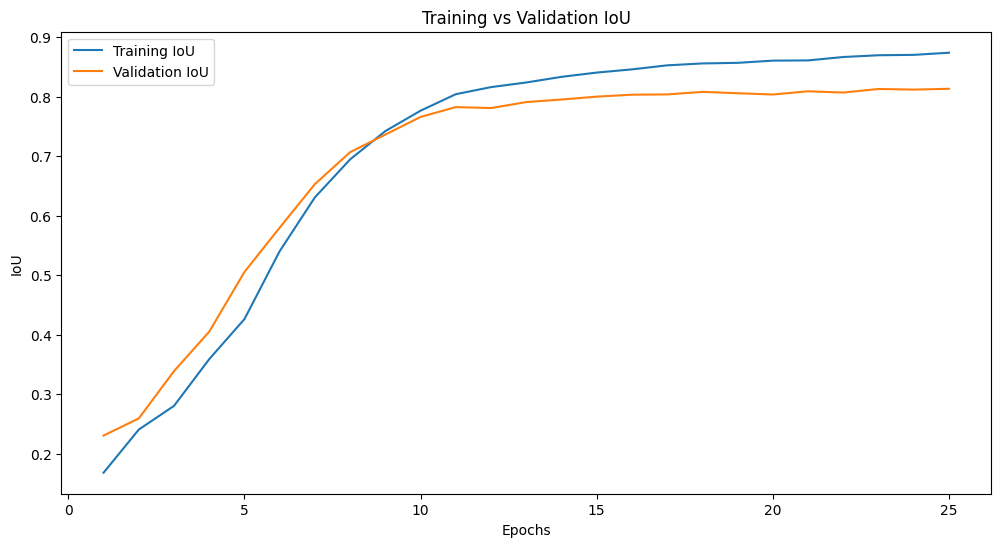

In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import random
import segmentation_models_pytorch as smp

def compute_iou(pred, target, num_classes):
    pred = (pred > 0.5).float()
    intersection = torch.sum(pred * target, dim=(1, 2))
    union = torch.sum((pred + target) > 0, dim=(1, 2))
    iou = (intersection + 1e-10) / (union + 1e-10)
    return torch.mean(iou).item()

class MulticlassHipSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, image_files, mask_files, num_classes, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.num_classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        dicom_image = pydicom.dcmread(os.path.join(self.img_root, self.img_files[idx]))
        image = dicom_image.pixel_array.astype(np.float32)
        annotation = nib.load(os.path.join(self.mask_root, self.mask_files[idx]))
        annotation_data = annotation.get_fdata()
        if len(annotation_data.shape) == 3:
            annotation_data = annotation_data[:, :, 0]
        annotation_data = np.rot90(annotation_data, k=7)
        if annotation_data.ndim > 2 and annotation_data.shape[-1] != 1:
            raise ValueError('Mask has multiple channels')

        if image.shape != annotation_data.shape:
            zoom_factors = np.array(image.shape) / np.array(annotation_data.shape)
            annotation_data = zoom(annotation_data, zoom_factors, order=0)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]

        annotation_data_onehot = self.one_hot_encode(annotation_data)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=annotation_data_onehot)
            image = transformed["image"]
            annotation_data_onehot = transformed["mask"]

        return image, annotation_data_onehot

    def one_hot_encode(self, mask):
        one_hot_mask = np.zeros((self.num_classes, *mask.shape), dtype=np.float32)
        for class_idx in range(self.num_classes):
            one_hot_mask[class_idx][mask == class_idx] = 1.0
        return one_hot_mask



image_files = sorted(os.listdir(img_root))
mask_files = sorted(os.listdir(mask_root))
paired_files = list(zip(image_files, mask_files))
random.shuffle(paired_files)

train_size = int(0.7 * len(paired_files))
valid_size = int(0.1 * len(paired_files))
test_size = len(paired_files) - train_size - valid_size

train_pairs = paired_files[:train_size]
valid_pairs = paired_files[train_size:train_size + valid_size]
test_pairs = paired_files[train_size + valid_size:]

num_classes = 7

augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
], is_check_shapes=False)

train_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in train_pairs], [p[1] for p in train_pairs], num_classes, transforms=augmentations)
valid_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in valid_pairs], [p[1] for p in valid_pairs], num_classes, transforms=augmentations)
test_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in test_pairs], [p[1] for p in test_pairs], num_classes, transforms=augmentations)

model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    classes=num_classes,
)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

num_epochs = 25

train_ious = []
valid_ious = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=16, shuffle=False, num_workers=2)

best_valid_iou = 0.0
best_model_path = 'best_unet_resnet18_multiclass_model_weights.pth'

for epoch in range(num_epochs):
    model.train()
    train_epoch_iou = 0

    for batch in train_loader:
        images, masks = batch
        optimizer.zero_grad()
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        batch_iou = compute_iou((outputs.sigmoid() > 0.5).float(), masks, num_classes)
        train_epoch_iou += batch_iou

    train_epoch_iou /= len(train_loader)
    train_ious.append(train_epoch_iou)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training IoU: {train_epoch_iou}")

    model.eval()
    valid_epoch_iou = 0

    with torch.no_grad():
        for batch in valid_loader:
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            batch_iou = compute_iou((outputs.sigmoid() > 0.5).float(), masks, num_classes)

            valid_epoch_iou += batch_iou

    valid_epoch_iou /= len(valid_loader)
    valid_ious.append(valid_epoch_iou)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation IoU: {valid_epoch_iou}")

    if valid_epoch_iou > best_valid_iou:
        best_valid_iou = valid_epoch_iou
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch + 1}/{num_epochs}, Model saved with Validation IoU: {best_valid_iou}")
    else:
        print(f"Epoch {epoch + 1}/{num_epochs}, Model not saved, Validation IoU: {valid_epoch_iou}")

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print(f"Best model loaded with Validation IoU: {best_valid_iou}")
else:
    print("No best model found.")

plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_ious, label='Training IoU')
plt.plot(range(1, num_epochs + 1), valid_ious, label='Validation IoU')
plt.title('Training vs Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


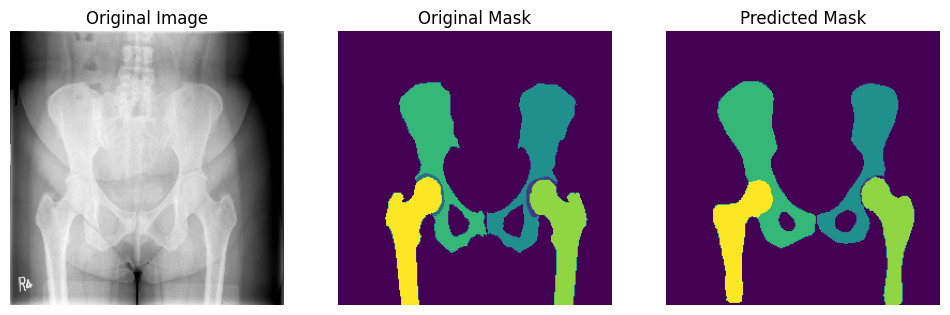

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

test_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in test_pairs], [p[1] for p in test_pairs], num_classes, transforms=augmentations)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

def visualize_single_sample(test_loader, model):
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            images, masks = batch
            outputs = model(images)
            original_mask = torch.argmax(masks.squeeze(0), dim=0).cpu().numpy()
            predicted_mask = torch.argmax(outputs.squeeze(0), dim=0).cpu().numpy()
            image = images.squeeze(0).permute(1, 2, 0).cpu().numpy()

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(image, cmap='gray')
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(original_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
            plt.title('Original Mask')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(predicted_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.show()
            break

visualize_single_sample(test_loader, model)

In [ ]:

test_ious = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        images, masks = batch
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        batch_iou = compute_iou((outputs.sigmoid() > 0.5).float(), masks, num_classes)
        test_ious.append(batch_iou)

test_mean_iou = np.mean(test_ious)

print(f"Test Mean IoU: {test_mean_iou}")



Test Mean IoU: 0.8743247515924515


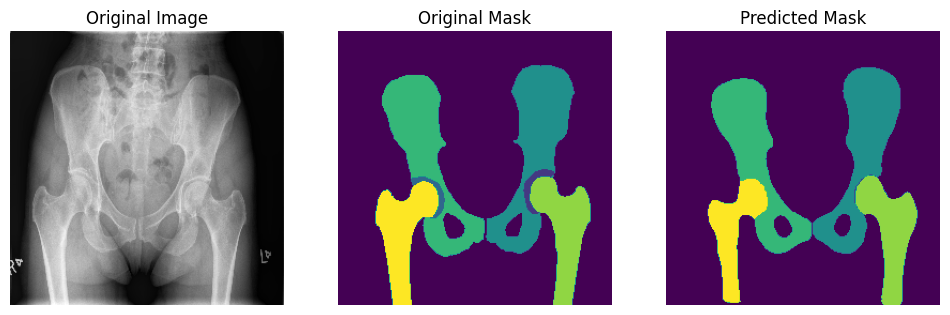

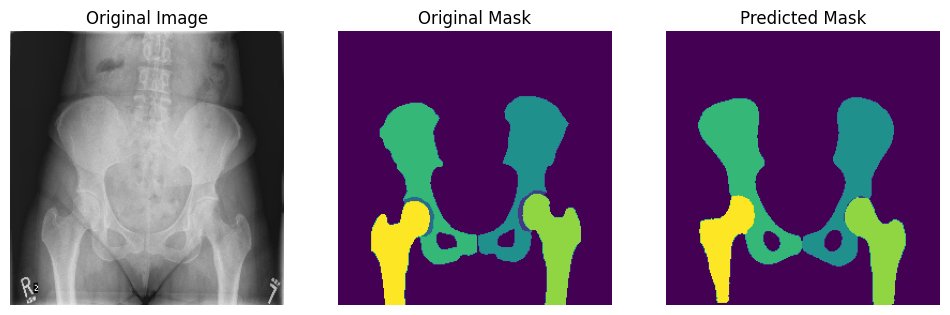

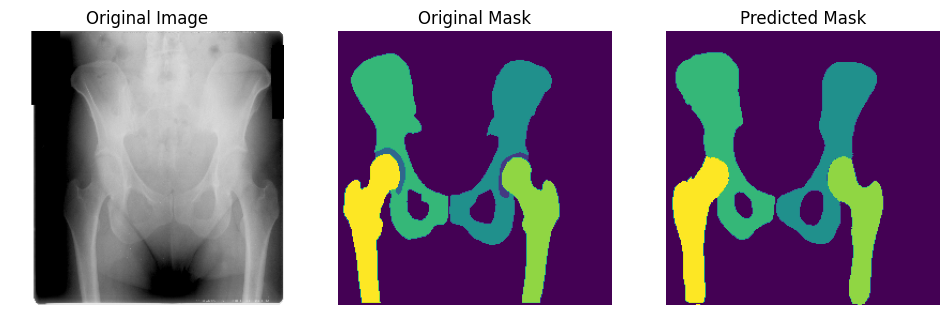

/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


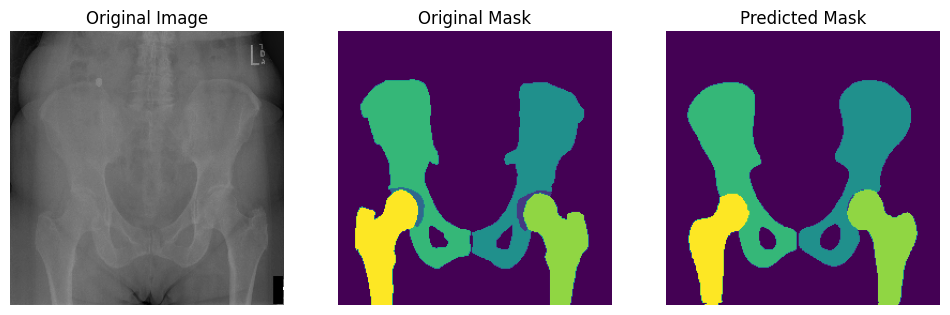

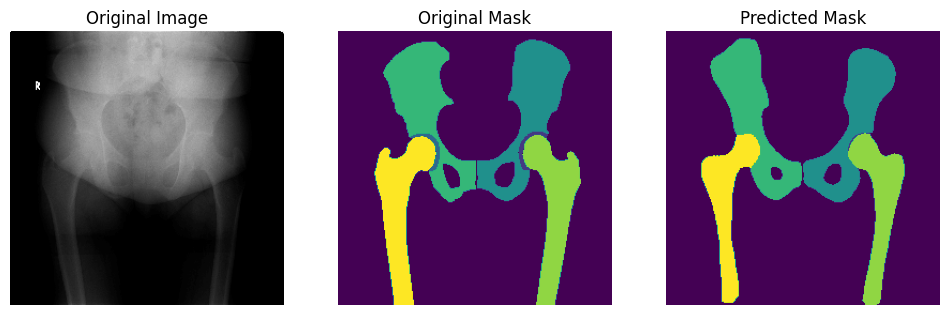

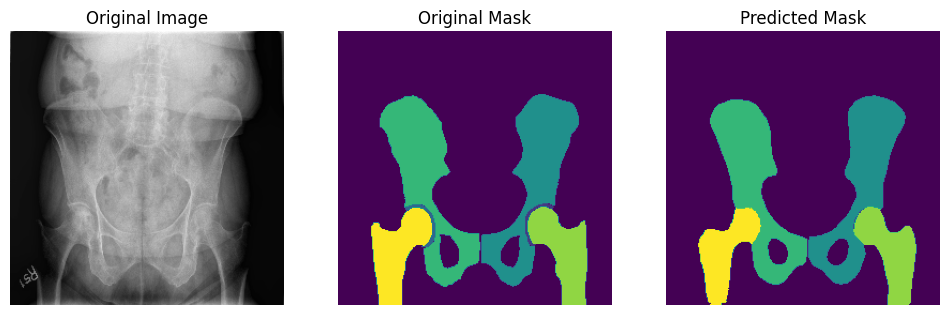

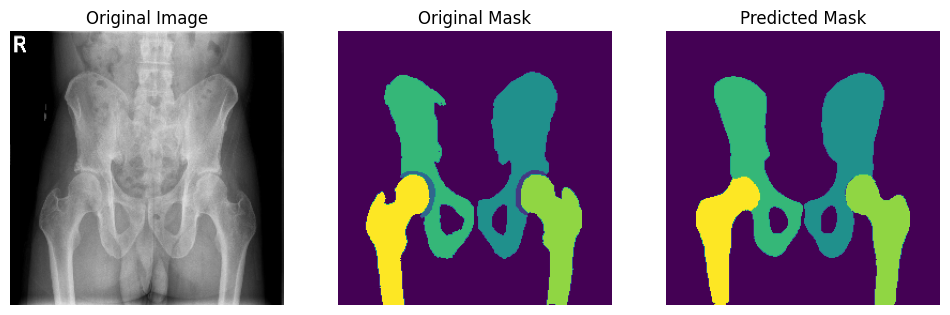

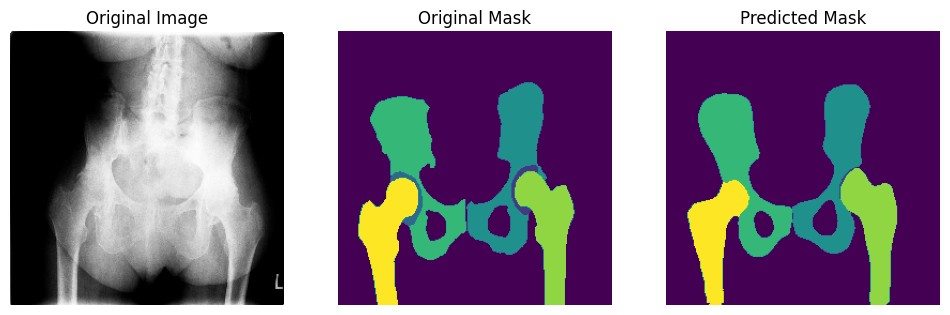

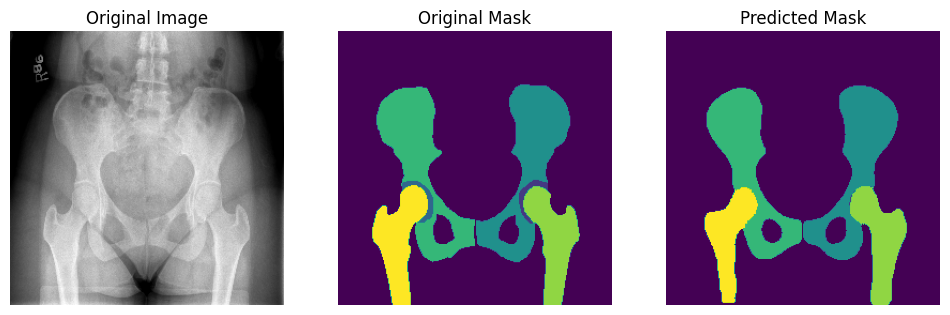

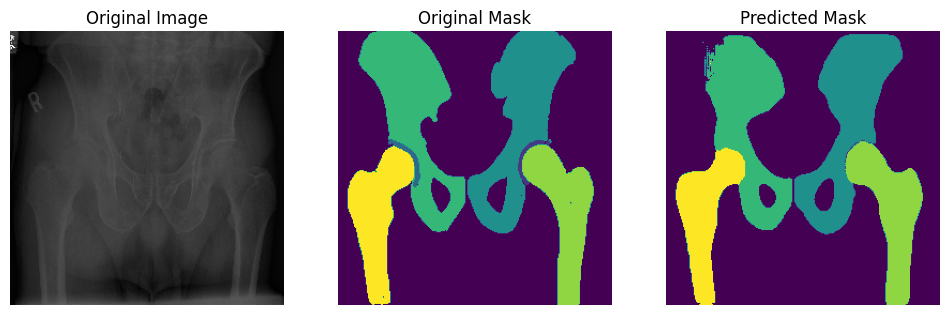

In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
import torch
import random
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

def compute_iou(pred, target, num_classes):
    pred = (pred > 0.5).float()
    intersection = torch.sum(pred * target, dim=(1, 2))
    union = torch.sum((pred + target) > 0, dim=(1, 2))
    iou = (intersection + 1e-10) / (union + 1e-10)
    return torch.mean(iou).item()

class MulticlassHipSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, image_files, mask_files, num_classes, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.num_classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        dicom_image = pydicom.dcmread(os.path.join(self.img_root, self.img_files[idx]))
        image = dicom_image.pixel_array.astype(np.float32)
        annotation = nib.load(os.path.join(self.mask_root, self.mask_files[idx]))
        annotation_data = annotation.get_fdata()
        if len(annotation_data.shape) == 3:
            annotation_data = annotation_data[:, :, 0]
        annotation_data = np.rot90(annotation_data, k=3)
        if annotation_data.ndim > 2 and annotation_data.shape[-1] != 1:
            raise ValueError('Mask has multiple channels')

        if image.shape != annotation_data.shape:
            zoom_factors = np.array(image.shape) / np.array(annotation_data.shape)
            annotation_data = zoom(annotation_data, zoom_factors, order=0)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]

        annotation_data_onehot = self.one_hot_encode(annotation_data)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=annotation_data_onehot)
            image = transformed["image"]
            annotation_data_onehot = transformed["mask"]

        return image, annotation_data_onehot

    def one_hot_encode(self, mask):
        one_hot_mask = np.zeros((self.num_classes, *mask.shape), dtype=np.float32)
        for class_idx in range(self.num_classes):
            one_hot_mask[class_idx][mask == class_idx] = 1.0
        return one_hot_mask

image_files = sorted(os.listdir(img_root))
mask_files = sorted(os.listdir(mask_root))

paired_files = list(zip(image_files, mask_files))

random.shuffle(paired_files)

train_size = int(0.7 * len(paired_files))
valid_size = int(0.1 * len(paired_files))
test_size = len(paired_files) - train_size - valid_size

train_pairs = paired_files[:train_size]
valid_pairs = paired_files[train_size:train_size + valid_size]
test_pairs = paired_files[train_size + valid_size:]

augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
], is_check_shapes=False)

num_classes = 7
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=1,
    classes=num_classes,
)

saved_model_path = 'best_unet_resnet18_multiclass_model_weights.pth'
checkpoint = torch.load(saved_model_path)
model.load_state_dict(checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def create_test_loader(test_pairs, augmentations, num_classes):
    test_set = MulticlassHipSegmentationDataset(
        img_root,
        mask_root,
        [p[0] for p in test_pairs],
        [p[1] for p in test_pairs],
        num_classes,
        transforms=augmentations
    )
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    return test_loader

def visualize_single_sample(images, masks, model):
    model.eval()
    with torch.no_grad():
        images = images.squeeze(0)
        masks = masks.squeeze(0)
        outputs = model(images.unsqueeze(0))
        original_mask = torch.argmax(masks, dim=0).cpu().numpy()
        predicted_mask = torch.argmax(outputs.squeeze(0), dim=0).cpu().numpy()
        image = images.permute(1, 2, 0).cpu().numpy()


        if image.shape[-1] == 1:
            image = image.squeeze(-1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(original_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
        plt.title('Original Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

random_10_pairs = random.sample(test_pairs, 10)

random_10_loader = create_test_loader(random_10_pairs, augmentations, num_classes)

for images, masks in random_10_loader:
    visualize_single_sample(images, masks, model)
